In [24]:
import sys
import pandas as pd


In [25]:
import os
print('cwd:', os.getcwd())
print('\nfiles in cwd:')
for f in sorted(os.listdir('.')):
    print(f)

cwd: /home/mengsrun/Desktop/scraper/ebay-scrapping

files in cwd:
.DS_Store
.git
.venv
Iphone Data
Pixel 7 Pro.csv
Pixel Data
Samsung S-series Data
analysis_iphone.ipynb
ebay_iphone.html
final_scraper.py
playwright_rendered.html
scrap.ipynb
scrap.py
scrape_with_playwright.py


In [35]:
from pathlib import Path
import pandas as pd

p = Path.cwd()

# candidate names to try first
candidates = [p / 'Pixel 7 Pro.csv', p / 'pixel 7 Pro.csv', p / 'pixel_7_pro.csv']

# add glob matches
candidates += list(p.glob('*[Pp]ixel*7*Pro*.csv'))

# filter existing, keep order and unique
seen = set()
candidates = [c for c in candidates if c.exists() and str(c) not in seen and not seen.add(str(c))]

if not candidates:
    raise FileNotFoundError(f"No Pixel 7 Pro CSV found in {p}; files: {sorted([x.name for x in p.iterdir()])}")

data_path = candidates[0]
print('Using file:', data_path)

data = pd.read_csv(data_path)

data.head()

Using file: /home/mengsrun/Desktop/scraper/ebay-scrapping/Pixel 7 Pro.csv


,Page,Title,Price,Sold Date,Link,Image Link
0,1,Google Pixel 7a | 7 | 7 Pro - 128GB 256GB 512G...,$194.95,"Sold Oct 21, 2025",https://www.ebay.com/itm/186577116952,https://i.ebayimg.com/images/g/SMoAAOSw9NZmmrF...
1,1,Google Pixel 6 - 6 Pro - 128/256 GB - Unlocked...,$154.99,"Sold Oct 21, 2025",https://www.ebay.com/itm/175221332529,https://i.ebayimg.com/images/g/2-sAAOSwl1diRJt...
2,1,Google Pixel 7 | 7a | 7 Pro - 128GB 256GB 512G...,$179.95,"Sold Oct 20, 2025",https://www.ebay.com/itm/276557533467,https://i.ebayimg.com/images/g/haoAAOSw605mkYO...
3,1,"Google Pixel 7 Pro 5G (128GB, 12GB) 6.7"" Fully...",$289.99,"Sold Aug 2, 2025",https://www.ebay.com/itm/134779506570,https://i.ebayimg.com/images/g/2cAAAeSwyYBoQf8...
4,1,Google Pixel 7 Pro Unlocked All Colors/Memory ...,$259.99,"Sold Oct 20, 2025",https://www.ebay.com/itm/126921454911,https://i.ebayimg.com/images/g/c6oAAOSwz-xnopd...


In [27]:
data['Date'] = data['Sold Date'].apply(lambda x: x.replace('Sold ', ''))

In [38]:
import re

# ---------- Helpers ----------

# Robust storage: first occurrence like "128GB", "256 GB"
def extract_storage(title: str) -> str:
    m = re.search(r'(\d{2,4})\s?GB\b', title, flags=re.IGNORECASE)
    return f"{m.group(1)} GB" if m else "Unknown"

def extract_condition(title: str) -> str:
    if 'Excellent' in title:
        return 'Excellent'
    elif 'Very' in title:
        return 'Very Good'
    elif 'Good' in title:
        return 'Good'
    else:
        return 'Unknown'

# Capture Google Pixel model tokens (7, 7a, 7 Pro, 6, 6 Pro, 6 XL, etc.)
MODEL_RE = re.compile(
    r'(?:Google\s+)?Pixel\s+((?:[1-9][0-9]?)(?:\s?(?:Pro|XL|a))?)\b(?:\s*5G)?',
    flags=re.IGNORECASE
)

def normalize_model_token(token: str) -> str | None:
    t = re.sub(r'\s+', ' ', token.strip())
    m = re.match(r'^([1-9][0-9]?)(?:\s?(Pro|XL|a))?$', t, flags=re.IGNORECASE)
    if not m:
        return None
    num = m.group(1)
    suf = m.group(2)
    if not suf:
        return f'Pixel {num}'
    suf_l = suf.lower()
    if suf_l == 'pro':
        return f'Pixel {num} Pro'
    if suf_l == 'xl':
        return f'Pixel {num} XL'
    if suf_l == 'a':
        return f'Pixel {num}a'
    return None

def extract_single_model_or_none(title: str) -> str | None:
    tokens = [m.group(1) for m in MODEL_RE.finditer(title)]
    models = []
    for tok in tokens:
        canon = normalize_model_token(tok)
        if canon:
            models.append(canon)
    # dedupe, keep order
    models = list(dict.fromkeys(models))
    return models[0] if len(models) == 1 else None  # None if 0 or >1 models

# ---------- Pipeline ----------

# 1) Add basic columns
data['Storage']   = data['Title'].apply(extract_storage)
data['Condition'] = data['Title'].apply(extract_condition)
data['PartsOnly'] = data['Title'].str.contains('Parts Only', case=False, regex=False)

# 2) Extract a single, unambiguous model (None if multiple or none)
data['Model'] = data['Title'].apply(extract_single_model_or_none)

# 3) Keep only rows with exactly one model (drop multi-option titles)
clean = data[data['Model'].notna()].copy()

# 4) '7 Pro' flag based on clean Model (no regex gotchas)
clean['7 Pro'] = (clean['Model'] == 'Pixel 7 Pro')

# 5) (Optional) If you also want to force-drop anything with a '|' regardless:
# clean = clean[~clean['Title'].str.contains(r'\|')]

# 6) Show relevant columns
clean[['Storage', 'Title', 'Condition', 'PartsOnly', 'Model', '7 Pro']]


,Storage,Title,Condition,PartsOnly,Model,7 Pro
0,128 GB,Google Pixel 7a | 7 | 7 Pro - 128GB 256GB 512G...,Unknown,False,Pixel 7a,False
1,256 GB,Google Pixel 6 - 6 Pro - 128/256 GB - Unlocked...,Excellent,False,Pixel 6,False
2,128 GB,Google Pixel 7 | 7a | 7 Pro - 128GB 256GB 512G...,Unknown,False,Pixel 7,False
3,128 GB,"Google Pixel 7 Pro 5G (128GB, 12GB) 6.7"" Fully...",Unknown,False,Pixel 7 Pro,True
4,Unknown,Google Pixel 7 Pro Unlocked All Colors/Memory ...,Excellent,False,Pixel 7 Pro,True
...,...,...,...,...,...,...
137,256 GB,Google Pixel 7 Pro 256GB (Unlocked) - Hazel,Unknown,False,Pixel 7 Pro,True
138,128 GB,Google Pixel 7 Pro - 128GB - Black White Hazel...,Good,False,Pixel 7 Pro,True
139,128 GB,Google Pixel 7 Pro 128GB Unlocked - Excellent,Excellent,False,Pixel 7 Pro,True
140,128 GB,Google Pixel 7 Pro 5G UW GE2AE 128GB Verizon U...,Very Good,False,Pixel 7 Pro,True


In [40]:
# 7) Filter only rows where '7 Pro' == True
pixel7pro = clean[clean['7 Pro'] == True].copy()

# 8) Export to CSV
pixel7pro.to_csv('pixel7pro_only.csv', index=False)

print(f"Exported {len(pixel7pro)} rows to pixel7pro_only.csv")


Exported 109 rows to pixel7pro_only.csv


In [41]:
pixel7pro.head()


,Page,Title,Price,Sold Date,Link,Image Link,Storage,Condition,PartsOnly,7 Pro,Model
3,1,"Google Pixel 7 Pro 5G (128GB, 12GB) 6.7"" Fully...",$289.99,"Sold Aug 2, 2025",https://www.ebay.com/itm/134779506570,https://i.ebayimg.com/images/g/2cAAAeSwyYBoQf8...,128 GB,Unknown,False,True,Pixel 7 Pro
4,1,Google Pixel 7 Pro Unlocked All Colors/Memory ...,$259.99,"Sold Oct 20, 2025",https://www.ebay.com/itm/126921454911,https://i.ebayimg.com/images/g/c6oAAOSwz-xnopd...,Unknown,Excellent,False,True,Pixel 7 Pro
5,1,Google Pixel 7 Pro 256GB Unlocked - Good,$259.99,"Sold Oct 20, 2025",https://www.ebay.com/itm/256235712897,https://i.ebayimg.com/images/g/4v0AAeSw21hoWck...,256 GB,Good,False,True,Pixel 7 Pro
6,1,Google Pixel 7 Pro 256GB Unlocked - Very Good,$279.99,"Sold Oct 20, 2025",https://www.ebay.com/itm/256299730104,https://i.ebayimg.com/images/g/lgUAAeSwIkZoWci...,256 GB,Very Good,False,True,Pixel 7 Pro
7,1,Google Pixel 7 Pro 128GB 256GB 512GB 50MP Fact...,$229.88,"Sold Apr 23, 2025",https://www.ebay.com/itm/187159693845,https://i.ebayimg.com/images/g/9mIAAOSwX2BoBWB...,128 GB,Good,False,True,Pixel 7 Pro


In [39]:
data['Title'].apply(lambda x: x.count('|')).value_counts()

# Get ram based on GB suffix
data['Storage'] = data['Title'].apply(lambda x: x[x.find('GB')-3:x.find('GB')].strip() if 'GB' in x else 'Unknown')

#Get the condition based on the first part of the title
def extract_condition(title):
    if 'Excellent' in title:
        return 'Excellent'
    elif 'Very' in title:
        return 'Very Good'
    elif 'Good' in title:
        return 'Good'
    else:
        return 'Unknown'

data['Condition'] = data['Title'].apply(extract_condition)
data['PartsOnly'] = data['Title'].apply(lambda x: 'Parts Only' in x)
data['7 Pro'] = (data['Title'].str.contains('7 Pro')) & (~data['Title'].str.contains('|'))
def extract_model(title):
    match = re.search(r'Google\s+Pixel\s+[0-9a-zA-Z\s]+', title)
    return match.group(0).strip() if match else 'Unknown'


# Now show the relevant columns
data[['Storage', 'Title', 'Condition', 'PartsOnly', '7 Pro']]

# data['7 Pro'].value_counts()



,Storage,Title,Condition,PartsOnly,7 Pro
0,128,Google Pixel 7a | 7 | 7 Pro - 128GB 256GB 512G...,Unknown,False,False
1,56,Google Pixel 6 - 6 Pro - 128/256 GB - Unlocked...,Excellent,False,False
2,128,Google Pixel 7 | 7a | 7 Pro - 128GB 256GB 512G...,Unknown,False,False
3,128,"Google Pixel 7 Pro 5G (128GB, 12GB) 6.7"" Fully...",Unknown,False,False
4,Unknown,Google Pixel 7 Pro Unlocked All Colors/Memory ...,Excellent,False,False
...,...,...,...,...,...
137,256,Google Pixel 7 Pro 256GB (Unlocked) - Hazel,Unknown,False,False
138,128,Google Pixel 7 Pro - 128GB - Black White Hazel...,Good,False,False
139,128,Google Pixel 7 Pro 128GB Unlocked - Excellent,Excellent,False,False
140,128,Google Pixel 7 Pro 5G UW GE2AE 128GB Verizon U...,Very Good,False,False


In [29]:
data['Date'] = pd.to_datetime(data['Date'])

In [30]:
data['Price'] = data['Price'].apply(lambda x: x.replace('$','').replace(',','')).astype(float)

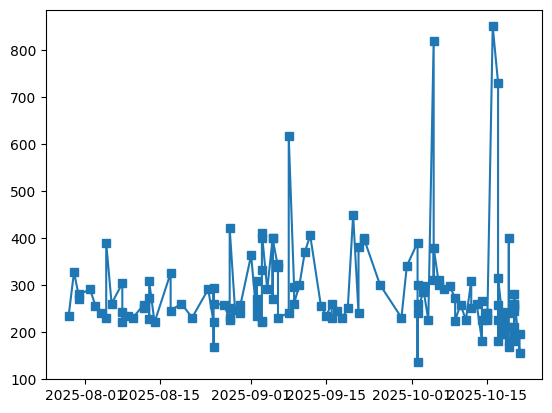

In [31]:
filtered = data.sort_values('Date')[10:]

# import matplotlib 

from matplotlib import pyplot as plt

plt.plot(filtered['Date'], filtered['Price'], marker='s')

In [32]:
#Clean the data: Kepp only 7 Pro models and categoriesze it to 

#1. Good, Very Good , Excellent Refurbished 
#2. Storage 
#3. Date Sold

In [33]:
#Multiple Regression 

# Price = β0 + β1(Storage) + β2(Condition) + β3(Date Sold) + ε
